In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from scipy import stats
import matplotlib as mpl
import itertools

In [2]:
#load introns and divide by sense

Introns=pd.read_csv('/Volumes/Storage3/Paramecium.FromChunlong/Data/NMD/20140122.Intron.Count.WTandNMD.Mac51.Validated.tab',sep='\t')

Introns=Introns.query('(Scaffold < 167 or Scaffold==556 ) and WT_Spl > WT_Ret+WT_AS')
del Introns['Gene_ID']
Introns_neg=Introns.query("Sense==-1")
Introns_pos=Introns.query("Sense==1")

In [3]:
# load new exons annotation and divide by sense
exons=pd.read_csv('/Users/sgnan/Desktop/paramecium/Genes/ptetraurelia_mac_51_annotation_v2.0.gff3',sep='\t',skiprows=2,names=['Scaffold','EuGene','feature','Exon_start_Mac51','Exon_end_Mac51','dot','strand','value','Info']).query('feature=="exon"')
exons=exons.assign(
    Scaffold=exons.Scaffold.apply(lambda x: x.split('_')[1]).astype(int),
    Gene_ID=exons.Info.apply(lambda x: x.split('ID=')[1]).apply(lambda x: x.split(':')[0]),
    Sense=exons.strand.apply(lambda x: -1 if x =='-' else 1)

).query('Scaffold < 167  or Scaffold==556').filter(['Scaffold','Exon_start_Mac51','Exon_end_Mac51','Sense','Gene_ID'])

Exons_neg=exons.query("Sense==-1").filter(['Scaffold','Exon_start_Mac51','Exon_end_Mac51','Gene_ID','Sense'])
Exons_pos=exons.query("Sense==1").filter(['Scaffold','Exon_start_Mac51','Exon_end_Mac51','Gene_ID','Sense'])

In [4]:
# attach preovious and following exon to each intron
Introns_neg=Introns_neg.merge(Exons_neg.assign(Intron_start_Mac51=Exons_neg.Exon_end_Mac51+1), how='inner',on=['Scaffold','Intron_start_Mac51','Sense']).rename(columns={"Exon_start_Mac51":"nextExon_start_Mac51",
                                                                                      "Exon_end_Mac51":"nextExon_end_Mac51"
                                                                                     }
).merge(Exons_neg.assign(Intron_stop_Mac51=Exons_neg.Exon_start_Mac51-1), how='inner',on=['Scaffold','Gene_ID','Intron_stop_Mac51','Sense']).rename(columns={"Exon_start_Mac51":"prevExon_start_Mac51",
                                                                                      "Exon_end_Mac51":"prevExon_end_Mac51"
                                                                                     })

Introns_pos=Introns_pos.merge(Exons_pos.assign(Intron_stop_Mac51=Exons_pos.Exon_start_Mac51-1), how='inner',on=['Scaffold','Intron_stop_Mac51','Sense']).rename(columns={"Exon_start_Mac51":"nextExon_start_Mac51",
                                                                                      "Exon_end_Mac51":"nextExon_end_Mac51"
                                                                                     }
).merge(Exons_pos.assign(Intron_start_Mac51=Exons_pos.Exon_end_Mac51+1), how='inner',on=['Scaffold','Gene_ID','Intron_start_Mac51','Sense']).rename(columns={"Exon_start_Mac51":"prevExon_start_Mac51",
                                                                                      "Exon_end_Mac51":"prevExon_end_Mac51"
                                                                                     })



In [5]:
# concatenate introns
Introns_info=pd.concat([Introns_neg,Introns_pos],axis=0)

In [6]:
100*(Introns_info.shape[0])/Introns.shape[0]

98.73982709582945

In [7]:
# tanscrip info
Transcript=exons.groupby(['Gene_ID']).agg({'Exon_start_Mac51':'min','Exon_end_Mac51':'max'})
Transcript=Transcript.reset_index().rename(columns={'Exon_start_Mac51':'Transcript_start_Mac51','Exon_end_Mac51':'Transcript_end_Mac51'})
Transcript=Transcript.assign(
Transcript_size=Transcript.Transcript_end_Mac51.values-Transcript.Transcript_start_Mac51.values
)

In [8]:
Introns_info=Introns_info.merge(Transcript)

In [9]:
#load peaks and add center
Peaks=pd.read_csv('/Users/sgnan/Desktop/paramecium/common_Nucleosome_peaks.bed',sep='\t',names=['Scaffold','start','end'])
Peaks['center']=(Peaks.start.values+Peaks.end.values)/2
#prepare genes to calculate distance form center
Introns_info=Introns_info.assign(
    center=(Introns_info.Intron_start_Mac51.values+Introns_info.Intron_stop_Mac51.values)/2,
    width=1+Introns_info.Intron_stop_Mac51.values-Introns_info.Intron_start_Mac51.values,
    distance_center=np.nan,
    density=np.nan)

In [10]:
#calculate distance from the center of the closest nucleosome
Scaffold_list2=np.unique(Peaks.Scaffold.values)
for scaffold in Scaffold_list2:
    Introns_info[Introns_info.Scaffold==scaffold]=Introns_info[Introns_info.Scaffold==scaffold].assign(
        distance_center=np.asarray(np.min(abs(np.matrix(Introns_info.query('Scaffold=='+str(scaffold)).center.values)-np.matrix(Peaks.query('Scaffold=='+str(scaffold)).center.values).T),axis=0))[0],
        density=np.array(np.abs(np.diff(np.sort(abs(np.matrix(Introns_info.query('Scaffold=='+str(scaffold)).center.values)-np.matrix(Peaks.query('Scaffold=='+str(scaffold)).center.values).T),axis=0)[0:2,:],axis=0)))[0]
    )


In [11]:
# drop missing values
Introns_info=Introns_info.dropna()
# select features
Introns_info=Introns_info[['Sense','Strong_donor','Strong_acceptor','Gene_ID','Scaffold','Intron_start_Mac51','Intron_stop_Mac51','WT_Spl','WT_Ret','WT_AS','NMD_Spl', 'NMD_Ret', 'NMD_AS','RPKM_WT','distance_center','nextExon_end_Mac51','nextExon_start_Mac51','prevExon_end_Mac51','prevExon_start_Mac51','Intron_position','Transcript_size','Transcript_start_Mac51','Transcript_end_Mac51','density']].reset_index(drop=True)
# convert features into integers
Introns_info[['nextExon_end_Mac51','nextExon_start_Mac51','prevExon_end_Mac51','prevExon_start_Mac51','Transcript_start_Mac51','Transcript_end_Mac51']]=Introns_info[['nextExon_end_Mac51','nextExon_start_Mac51','prevExon_end_Mac51','prevExon_start_Mac51','Transcript_start_Mac51','Transcript_end_Mac51']].astype(int)


In [12]:
# load genome sequece
fasta_dir='/Volumes/Storage3/Paramecium.FromChunlong/Data/Genome/mac_51/Scaffold/'
sequences=dict()
fasta_files=['20120207.scaffold51_'+str(i)+'.fa' for i in list(range(1,167))+[556]]
for i in list(range(1,167))+[556]:
    f = open(fasta_dir+'20120207.scaffold51_'+str(i)+'.fa','r')
    lines=f.readlines()[1:]
    f.close()
    sequences[i]=''.join([l.strip('\n') for l in lines])

In [13]:
# calculate GC content of the intron of interest
def GCcontent(sequences,Introns_info,i):
    intron=sequences[Introns_info.Scaffold.iloc[i]][(Introns_info.Intron_start_Mac51.iloc[i]+1):Introns_info.Intron_stop_Mac51.iloc[i]-2]
    GC=100*(intron.count('C')+intron.count('G'))/len(intron)
    return GC

# calculate GC content of the previous exon
def GCcontent_prev_ex(sequences,Introns_info,i):
    intron=sequences[Introns_info.Scaffold.iloc[i]][(Introns_info.prevExon_start_Mac51.iloc[i]-1):Introns_info.prevExon_end_Mac51.iloc[i]]
    GC=100*(intron.count('C')+intron.count('G'))/len(intron)
    return GC

# calculate GC content of the following exon
def GCcontent_next_ex(sequences,Introns_info,i):
    intron=sequences[Introns_info.Scaffold.iloc[i]][(Introns_info.nextExon_start_Mac51.iloc[i]-1):Introns_info.nextExon_end_Mac51.iloc[i]]
    GC=100*(intron.count('C')+intron.count('G'))/len(intron)
    return GC

# calculate GC content of the transcriptional unit
def GCcontent_Transcrip(sequences,Introns_info,i):
    intron=sequences[Introns_info.Scaffold.iloc[i]][(Introns_info.Transcript_start_Mac51.iloc[i]-1):Introns_info.Transcript_end_Mac51.iloc[i]]
    GC=100*(intron.count('C')+intron.count('G'))/len(intron)
    return GC

Introns_info=Introns_info.assign(
GC=[GCcontent(sequences,Introns_info,i) for i in range(len(Introns_info.index))],
GC_nextExon=[GCcontent_next_ex(sequences,Introns_info,i) for i in range(len(Introns_info.index))],
GC_prevExon=[GCcontent_prev_ex(sequences,Introns_info,i) for i in range(len(Introns_info.index))],
GC_Transcrip=[GCcontent_Transcrip(sequences,Introns_info,i) for i in range(len(Introns_info.index))]
)

In [14]:
# calculate sizes of enxons
Introns_info['nextExon_Size']=1+Introns_info.nextExon_end_Mac51-Introns_info.nextExon_start_Mac51
Introns_info['prevExon_Size']=1+Introns_info.prevExon_end_Mac51-Introns_info.prevExon_start_Mac51


In [15]:
#load nucleosome scores
data={
'D1':np.load('/Users/sgnan/Desktop/paramecium/tracks/D1_nucleosome_score.npy',allow_pickle='TRUE').item(),
'D2': np.load('/Users/sgnan/Desktop/paramecium/tracks/D2_nucleosome_score.npy',allow_pickle='TRUE').item(),
'S41': np.load('/Users/sgnan/Desktop/paramecium/tracks/S41_nucleosome_score.npy',allow_pickle='TRUE').item(),
'S32new': np.load('/Users/sgnan/Desktop/paramecium/tracks/S32new_nucleosome_score.npy',allow_pickle='TRUE').item()
}

In [16]:
# Average and correct normalise control
data['D']={scaffold:0.01+(data['D1'][scaffold]+data['D2'][scaffold])/2 for scaffold in data['D1'].keys()}
data['S']={scaffold:0.01+(data['S41'][scaffold]+data['S32new'][scaffold])/2 for scaffold in data['S32new'].keys()}

data['Norm']={scaffold:(data['S'][scaffold]/data['D'][scaffold]) for scaffold in data['S'].keys()}
# set nan and Inf to zero
for scaffold in data['Norm'].keys():
    data['Norm'][scaffold][np.isfinite(data['Norm'][scaffold])==False]=0

In [17]:
# calculate median nucleosome score over introns
def MNasesignal(sample_Track,Introns_info,i):
    intron=np.median(sample_Track[Introns_info.Scaffold.iloc[i]][(Introns_info.Intron_start_Mac51.iloc[i]):Introns_info.Intron_stop_Mac51.iloc[i]+1])
    return intron
# calculate median nucleosome score over following exon
def MNasesignal_next(sample_Track,Introns_info,i):
    intron=np.median(sample_Track[Introns_info.Scaffold.iloc[i]][(Introns_info.nextExon_start_Mac51.iloc[i]):Introns_info.nextExon_end_Mac51.iloc[i]+1])
    return intron
# calculate median nucleosome score over previous exon
def MNasesignal_prev(sample_Track,Introns_info,i):
    intron=np.median(sample_Track[Introns_info.Scaffold.iloc[i]][(Introns_info.prevExon_start_Mac51.iloc[i]):Introns_info.prevExon_end_Mac51.iloc[i]+1])
    return intron

Introns_info=Introns_info.assign(
MNase=[MNasesignal(data['Norm'],Introns_info,i) for i in range(len(Introns_info.index))],
MNase_nextExon=[MNasesignal_next(data['Norm'],Introns_info,i) for i in range(len(Introns_info.index))],
MNase_prevExon=[MNasesignal_prev(data['Norm'],Introns_info,i) for i in range(len(Introns_info.index))]
)

In [18]:
#calculate splicing efficiency and length of introns
Introns_info=Introns_info.assign(
Splice_eff_WT= (Introns_info.WT_Spl)/(Introns_info.WT_Spl+Introns_info.WT_Ret+Introns_info.WT_AS),
Splice_eff_NMD= (Introns_info.NMD_Spl)/(Introns_info.NMD_Spl+Introns_info.NMD_Ret+Introns_info.NMD_AS),
len_intron= 1+Introns_info.Intron_stop_Mac51-Introns_info.Intron_start_Mac51
).dropna()

#calculate n of introns in a transcript
Introns_info['Count'] =np.array(Introns_info.groupby('Gene_ID')['Gene_ID'].transform('count'))

In [19]:
# save to file 
Introns_info.to_csv('Gene_info_from_Model.tsv',sep='\t',index=False)

#function that applies a transformation and standardizes data
def norm_data_apply_function(x,FUN='A'):
    if FUN!='A':
        y=FUN(x)
    else:
        y=x
    y=(y-np.mean(y))/np.std(y)
    return(y)

Introns_info=Introns_info.assign(
    
#splicing efficiency
Splice_eff_WT=norm_data_apply_function(Introns_info.Splice_eff_WT,np.exp), 
Splice_eff_NMD=norm_data_apply_function(Introns_info.Splice_eff_NMD,np.exp), 

#RPKM
RPKM_WT=norm_data_apply_function(Introns_info.RPKM_WT,np.log10),

#local density
density=norm_data_apply_function(Introns_info.density),

#distance from center 
distance_center=norm_data_apply_function(Introns_info.distance_center),

    
#GC
GC=norm_data_apply_function(Introns_info.GC),
GC_nextExon=norm_data_apply_function(Introns_info.GC_nextExon),
GC_prevExon=norm_data_apply_function(Introns_info.GC_prevExon),
GC_Transcrip=norm_data_apply_function(Introns_info.GC_Transcrip),  


#MNase
MNase=norm_data_apply_function(Introns_info.MNase),
MNase_nextExon=norm_data_apply_function(Introns_info.MNase_nextExon),
MNase_prevExon=norm_data_apply_function(Introns_info.MNase_prevExon),
    
#size
Transcript_size=norm_data_apply_function(Introns_info.Transcript_size),
len_intron=norm_data_apply_function(Introns_info.len_intron),
nextExon_Size=norm_data_apply_function(Introns_info.nextExon_Size),
prevExon_Size=norm_data_apply_function(Introns_info.prevExon_Size),
    
#introns prop
Count=norm_data_apply_function(Introns_info.Count),
    
Intron_position=norm_data_apply_function(Introns_info.Intron_position)
)


In [20]:
List_par=[ 'RPKM_WT','distance_center','Intron_position','Transcript_size','GC', 'GC_nextExon','nextExon_Size',
          'prevExon_Size','GC_prevExon', 'GC_Transcrip', 'MNase', 'MNase_nextExon', 'MNase_prevExon', 'len_intron', 
          'Count','density']
full_list=['Splice_eff_WT','Splice_eff_NMD']+List_par

In [21]:
Introns_info[full_list].describe()

,Splice_eff_WT,Splice_eff_NMD,RPKM_WT,distance_center,Intron_position,Transcript_size,GC,GC_nextExon,nextExon_Size,prevExon_Size,GC_prevExon,GC_Transcrip,MNase,MNase_nextExon,MNase_prevExon,len_intron,Count,density
count,6.965800e+04,6.965800e+04,6.965800e+04,6.965800e+04,6.965800e+04,6.965800e+04,6.965800e+04,6.965800e+04,6.965800e+04,6.965800e+04,6.965800e+04,6.965800e+04,6.965800e+04,6.965800e+04,6.965800e+04,6.965800e+04,6.965800e+04,6.965800e+04
mean,4.045094e-12,1.321336e-12,-1.121753e-15,1.319364e-17,1.403778e-15,1.392999e-17,6.236811e-13,1.870825e-13,2.100176e-17,-1.238892e-16,1.530673e-13,-1.118475e-14,-7.456272e-15,2.236809e-14,7.447726e-15,-6.079332e-15,-1.398660e-15,8.596227e-17
std,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00
min,-5.372914e+00,-5.196656e+00,-3.621905e+00,-1.043480e+00,-8.564743e-01,-1.211025e+00,-2.050991e+00,-6.438460e+00,-7.231999e-01,-5.852835e-01,-6.663413e+00,-6.760029e+00,-1.781004e+00,-3.153967e+00,-3.028285e+00,-2.562571e+00,-1.263495e+00,-1.137742e+00
25%,-4.901510e-02,-5.397982e-02,-6.904943e-01,-5.166007e-01,-8.564743e-01,-5.626757e-01,-7.307346e-01,-6.795247e-01,-4.443104e-01,-3.834539e-01,-6.632979e-01,-7.129106e-01,-7.104038e-01,-6.359921e-01,-6.277586e-01,-8.607907e-01,-7.954927e-01,-7.391393e-01
50%,4.681651e-01,4.229886e-01,-1.319041e-01,-9.195196e-02,-3.152348e-01,-2.440664e-01,-7.060628e-02,-3.995696e-02,-2.962104e-01,-2.696402e-01,-3.109408e-02,-4.827374e-02,-2.304685e-01,-8.933112e-02,-9.229920e-02,-9.900464e-03,-3.274902e-01,-1.549808e-01
75%,5.428969e-01,5.760754e-01,5.783940e-01,2.068750e-01,2.260047e-01,1.907171e-01,6.995434e-01,6.354804e-01,4.230381e-02,-5.592487e-03,6.426524e-01,6.661538e-01,4.735174e-01,5.062725e-01,4.969191e-01,4.155447e-01,6.085148e-01,6.009892e-01
max,5.428969e-01,5.854068e-01,5.275546e+00,7.021888e+01,1.213327e+01,1.369961e+01,5.283768e+00,1.473306e+01,2.521353e+01,3.059663e+01,6.245117e+00,4.404133e+00,7.879914e+00,1.306402e+01,1.252872e+01,8.924447e+00,8.564557e+00,5.821277e+01


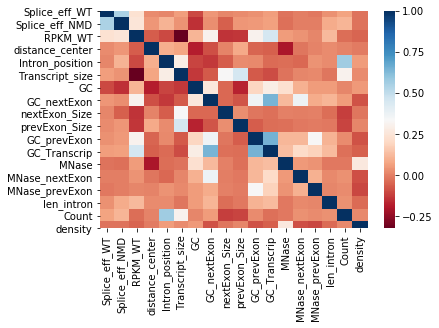

In [22]:
#check data correlation
# calculate the correlation matrix
corr = Introns_info[full_list].corr()

# plot the correlation heatmap
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap='RdBu')


In [23]:
# linear fit and calculate parameters
def fit_data(Introns_info,COL,list_par):
    old=0
    new=len(list_par)
    while (old != new):
        old=len(list_par)
        mat_Introns_info=np.matrix(Introns_info[list_par])

        X_train, X_test, y_train, y_test = train_test_split(mat_Introns_info,Introns_info[COL].values, test_size=0.1, random_state=0)
        Mult_lin= LinearRegression()
        Mult_lin.fit(X_train, y_train)

        newX = pd.DataFrame({"Constant":np.ones(len(X_train))}).join(pd.DataFrame(X_train))
        MSE = (sum((y_train-Mult_lin.predict(X_train))**2))/(len(newX)-len(newX.columns))

        var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
        sd_b = np.sqrt(var_b)
        ts_b =  np.append(Mult_lin.intercept_,Mult_lin.coef_)/ sd_b
        p_values =np.array([2*(1-stats.t.cdf(np.abs(i),(newX.shape[0]-newX.shape[1]))) for i in ts_b])
        params =np.append(Mult_lin.intercept_,Mult_lin.coef_)
        
        myDF3 = pd.DataFrame()
        myDF3["param"],myDF3["Coefficients"],myDF3["Standard Errors"],myDF3["t values"],myDF3["pVal"],myDF3["Sig"] = [['constant']+list_par,params,sd_b,ts_b,p_values,p_values < 0.01
    ]
        new=sum(myDF3.Sig)
        list_par=myDF3.query('Sig==True').param.tolist()

    return {'Info':myDF3.query('Sig==True'),'Model':Mult_lin,'X_test':X_test,'y_test':y_test,'list_par':list_par}



In [24]:
# caclulates contribution
def calculate_model_info(Mult_lin,corr,col_corr):
    coef_fd=pd.DataFrame({'coef':Mult_lin['Model'].coef_,'index':Mult_lin['list_par']})
    coef_fd=corr[col_corr].reset_index().merge(coef_fd, on='index', how='inner')
    coef_fd=coef_fd.assign(   CorCoef=abs(coef_fd[col_corr]*coef_fd.coef)
                              )
    TotalCorrelation=sum(coef_fd.CorCoef)
    coef_fd=coef_fd.assign(
            Contribution=100*(coef_fd.CorCoef)/TotalCorrelation
        ).sort_values(["Contribution"],ascending=False).merge(
            Mult_lin['Info'].rename(columns={'param':'index'}
                     ).filter(["index","Standard Errors","t values","pVal"]), on='index', how='inner')
    return coef_fd


In [25]:
#fit model using evry possible combination of parameters starting to 3 parameters to all of them
results=dict()
f=0
for i in range(2,len(List_par)):
    for List in list(itertools.combinations(List_par, i+1)):
        try:
            Mult_lin_NMD=fit_data(Introns_info,'Splice_eff_NMD',list(List))
            kept=calculate_model_info(Mult_lin_NMD,corr,'Splice_eff_NMD')['index']
            pears=pd.DataFrame({
                'Real_NMD':Mult_lin_NMD['y_test'],
                'Model_NMD':Mult_lin_NMD['Model'].predict(Mult_lin_NMD['X_test'])
                }).corr().Model_NMD[0]
            results[f]={'kept':list(kept),'corr':pears}
            f+=1
        except:
            pass

In [26]:
# identify best correlation
results_cor=np.array([results[i]['corr'] for i in results.keys()])
results_cor.max()

0.347274443787411

In [27]:
# identify iterations with the best correlation
W=np.where(results_cor==results_cor.max())[0]
W

array([50749, 58547, 58778, 58808, 58814, 58817, 58820, 62924, 62930,
       62933, 62936, 63099, 63105, 63108, 63111, 63130, 63133, 63136,
       63137, 63140, 63141, 64740, 64743, 64746, 64747, 64750, 64751,
       64825, 64828, 64831, 64832, 64835, 64836, 64843, 64846, 64847,
       64848, 65283, 65286, 65287, 65288, 65307, 65310, 65311, 65312,
       65314, 65389, 65392])

In [28]:
#check that they all use the same parameters
differences=dict()
for i in W:
    for h in W:
        differences[str(i)+'vs'+str(h)]=np.concatenate([list(set(results[i]['kept'])-set(results[h]['kept'])),list(set(results[h]['kept'])-set(results[i]['kept']))])
        
[d for d in differences.keys() if len(differences[d])>0]   

[]

In [29]:
# select one of the simulation with best correlation
selected_mode=50749
par=results[selected_mode]['kept']
par

['RPKM_WT',
 'GC',
 'Count',
 'Intron_position',
 'len_intron',
 'Transcript_size',
 'nextExon_Size',
 'prevExon_Size',
 'GC_Transcrip',
 'distance_center']

In [32]:
def fit_data_no_sel(genes_info,COL,list_par):
    mat_genes_info=np.matrix(genes_info[list_par])

    X_train, X_test, y_train, y_test = train_test_split(mat_genes_info,genes_info[COL].values, test_size=0.1, random_state=0)
    Mult_lin= LinearRegression()
    Mult_lin.fit(X_train, y_train)

    newX = pd.DataFrame({"Constant":np.ones(len(X_train))}).join(pd.DataFrame(X_train))
    MSE = (sum((y_train-Mult_lin.predict(X_train))**2))/(len(newX)-len(newX.columns))

    var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
    sd_b = np.sqrt(var_b)
    ts_b =  np.append(Mult_lin.intercept_,Mult_lin.coef_)/ sd_b
    p_values =np.array([2*(1-stats.t.cdf(np.abs(i),(newX.shape[0]-newX.shape[1]))) for i in ts_b])
    params =np.append(Mult_lin.intercept_,Mult_lin.coef_)

    myDF3 = pd.DataFrame()
    myDF3["param"],myDF3["Coefficients"],myDF3["Standard Errors"],myDF3["t values"],myDF3["pVal"],myDF3["Sig"] = [['constant']+list_par,params,sd_b,ts_b,p_values,p_values < 0.01
        ]

    return {'Info':myDF3,'Model':Mult_lin,'X_test':X_test,'y_test':y_test,'list_par':list_par}



In [34]:
Mult_lin_NMD=fit_data_no_sel(Introns_info,'Splice_eff_NMD',par)
data=calculate_model_info(Mult_lin_NMD,corr,'Splice_eff_NMD')
data

,index,Splice_eff_NMD,coef,CorCoef,Contribution,Standard Errors,t values,pVal
0,RPKM_WT,0.253003,0.305357,0.077256,60.089096,0.004468,68.336661,0.000000e+00
1,GC,-0.145865,-0.158833,0.023168,18.019885,0.004049,-39.226774,0.000000e+00
2,Count,0.113109,0.064504,0.007296,5.674774,0.005055,12.760640,0.000000e+00
3,Intron_position,0.107826,0.056297,0.006070,4.721385,0.004691,12.001010,0.000000e+00
4,len_intron,0.093238,0.062503,0.005828,4.532691,0.003791,16.488892,0.000000e+00
5,Transcript_size,0.040984,0.080604,0.003303,2.569382,0.005398,14.931744,0.000000e+00
6,nextExon_Size,-0.057617,-0.036489,0.002102,1.635203,0.004261,-8.563032,0.000000e+00
7,prevExon_Size,0.047426,0.029504,0.001399,1.088316,0.004587,6.431839,1.269735e-10
8,GC_Transcrip,0.067519,-0.019023,0.001284,0.998975,0.004388,-4.335216,1.458435e-05
9,distance_center,0.045311,0.019019,0.000862,0.670292,0.003752,5.069233,4.005569e-07


In [35]:
pd.DataFrame({
'Real_NMD':Mult_lin_NMD['y_test'],
'Model_NMD':Mult_lin_NMD['Model'].predict(Mult_lin_NMD['X_test'])
}).corr()

,Real_NMD,Model_NMD
Real_NMD,1.000000,0.347274
Model_NMD,0.347274,1.000000


In [36]:
Mult_lin_NMD['Model'].score(Mult_lin_NMD['X_test'],Mult_lin_NMD['y_test'])

0.12031513269127925

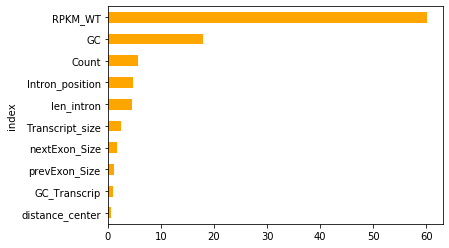

In [37]:
data.set_index(['index']).sort_values(['Contribution']).Contribution.plot(kind='barh',color='orange')
plt.savefig('Model_contribution.pdf',  format='pdf')